In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Define system parameters (Mass-Spring-Damper)
m = 1.0  # Mass
c = 0.2  # Damping coefficient
k = 1.0  # Spring constant

# Generate synthetic measurement data
t_data = np.linspace(0, 10, 100)
x_measured = np.sin(t_data)  # Simulated "measured" system response

# Convert measurement data to tensors
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
t_tensor = torch.tensor(t_data, dtype=torch.float32, device=device).unsqueeze(1)
x_measured_tensor = torch.tensor(x_measured, dtype=torch.float32, device=device).unsqueeze(1)

In [9]:
# Neural network to learn latent representation
class LatentNN(nn.Module):
    def __init__(self):
        super(LatentNN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 1)  # Latent representation (control force)
        )

    def forward(self, X):
        return self.net(X)

# Physical system using Euler integration in PyTorch
def simulate_mass_spring_damper(F, x0, v0, t_tensor):
    dt = t_tensor[1] - t_tensor[0]  # Time step
    x = x0
    v = v0
    x_list = [x]

    for i in range(1, len(t_tensor)):
        a = (F[i-1] - c * v - k * x) / m  # Acceleration from force
        v = v + a * dt  # Update velocity
        x = x + v * dt  # Update position
        x_list.append(x)

    return torch.stack(x_list)

In [10]:
# Initialize model and optimizer
model = LatentNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

# Training loop
epochs = 5000
for epoch in range(epochs):
    optimizer.zero_grad()

    # Neural network predicts latent force u(t)
    F_pred = model(t_tensor)

    # Simulate system using PyTorch operations (keeps gradients)
    x0 = torch.tensor([0.0], device=device)  # Initial displacement
    v0 = torch.tensor([0.0], device=device)  # Initial velocity
    x_simulated = simulate_mass_spring_damper(F_pred, x0, v0, t_tensor)

    # Compute loss by comparing simulated system output to measured data
    loss = loss_fn(x_simulated, x_measured_tensor)
    loss.backward()
    optimizer.step()

    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.6f}")


Epoch 0, Loss: 0.728250
Epoch 500, Loss: 0.002650
Epoch 1000, Loss: 0.000656
Epoch 1500, Loss: 0.000298
Epoch 2000, Loss: 0.000193
Epoch 2500, Loss: 0.000141
Epoch 3000, Loss: 0.000106
Epoch 3500, Loss: 0.000083
Epoch 4000, Loss: 0.000067
Epoch 4500, Loss: 0.000060


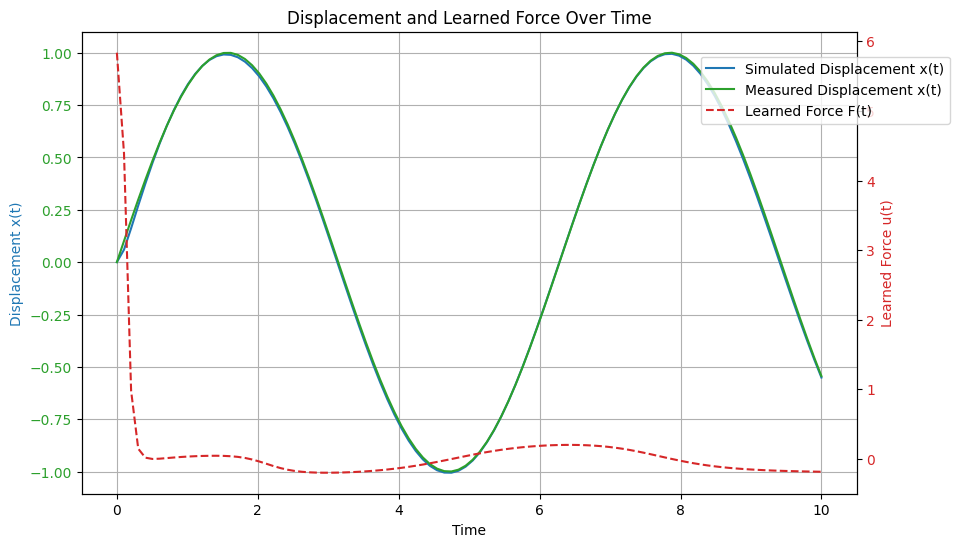

In [13]:
# Generate final results
# Extract simulation results for plotting
F_final = model(t_tensor).detach().cpu().numpy().flatten()  # Learned force
x_simulated_final = x_simulated.detach().cpu().numpy().flatten()  # Simulated displacement

# Plot x(t) and u(t) on the same plot with different y-axes
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot displacement x(t)
color = 'tab:blue'
ax1.set_xlabel('Time')
ax1.set_ylabel('Displacement x(t)', color=color)
ax1.plot(t_data, x_simulated_final, label="Simulated Displacement x(t)", color=color)
color = 'tab:green'
x_measured = x_measured_tensor.detach().cpu().numpy().flatten()  # Simulated displacement
ax1.plot(t_data, x_measured, label="Measured Displacement x(t)", color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True)

# Create a second y-axis for u(t)
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Learned Force u(t)', color=color)
ax2.plot(t_data, F_final, label="Learned Force F(t)", color=color, linestyle='dashed')
ax2.tick_params(axis='y', labelcolor=color)

# Add a combined title
plt.title("Displacement and Learned Force Over Time")

# Combine legends from both plots
fig.legend(loc='upper right', bbox_to_anchor=(1, 0.85))

# Show the plot
plt.show()
